In [1]:
import sys
sys.path.append("/home/hwpc03/workspace/ma-yang/Reproduction_KNN")

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# KNN Classifier
from sklearn import datasets  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,recall_score,classification_report,accuracy_score
import pandas as pd
import seaborn as sns

import random
from scipy import interpolate

# Hidden Semi Markov Model and LQR
This is an example of learning a HMM over some trajectories demonstrations and reproducing it using optimal control.
More infos : http://calinon.ch/papers/Calinon-JIST2015.pdf, http://calinon.ch/papers/Calinon-HFR2016.pdf


## Learning Hidden Markov Model (HSMM)

In [3]:
import random
def DataProcessing(data):
        data = np.array(data)
        nsamples, nx, ny = data.shape
        if nx > 200:                                                # delete randomly datapoints
            index = random.sample(range(1,nx), nx-200)
            demo_data = np.delete(data, index, axis=1)
            demo_data_dim2 = demo_data.reshape((nsamples,-1))
            return demo_data, demo_data_dim2
        elif nx < 200:                                               # Interpolation
            demo_data = []
            for k in range(len(data)):
                values = np.reshape(data[k],-1)
                points = np.array([[i,j] for i in range(0, nx) for j in range(0, ny)])
                grid_x, grid_y = np.mgrid[0:nx-1:200j, 0:ny-1:4j]
                data_new = interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')
                demo_data.append(data_new)
            demo_data = np.array(demo_data)
            demo_data_dim2 = demo_data.reshape((nsamples,-1))
            return demo_data, demo_data_dim2
        else:
            demo_data_dim2 = data.reshape((nsamples,-1))
            return data, demo_data_dim2

In [4]:
def separate_xdx(mydata_xdx):
    mydata_x = []
    mydata_dx = []
    if np.array(mydata_xdx).ndim == 3:
        for i in range(len(mydata_xdx)):
            temp_x = []
            temp_dx = []
            for j in range(len(mydata_xdx[i])):
                temp_x.append([mydata_xdx[i][j][0], mydata_xdx[i][j][1]])
                temp_dx.append([mydata_xdx[i][j][2], mydata_xdx[i][j][3]])
            temp_x1 = np.array(temp_x)
            temp_dx1 = np.array(temp_dx)
            mydata_x.append(temp_x1)
            mydata_dx.append(temp_dx1)
        return mydata_x, mydata_dx
    elif np.array(mydata_xdx).ndim == 2:
        temp_x = []
        temp_dx = []
        for i in range(len(mydata_xdx)):
            temp_x.append([mydata_xdx[i][0], mydata_xdx[i][1]])
            temp_dx.append([mydata_xdx[i][2], mydata_xdx[i][3]])
        return temp_x, temp_dx
    else:
        print("Error! The dimension of data is neither 2 or 3")

In [5]:
def create_hsmm_data(demo_pred):
    letter = demo_pred[0]
    files = ['demo%s'%letter, 'demo%s1'%letter, 'demo%s2'%letter, 'demo%s3'%letter, 'demo%s4'%letter, 'demo%s5'%letter, 'demo%s6'%letter, 'demo%s7'%letter, 'demo%s8'%letter, 'demo%s9'%letter]
    files.pop(0)

    train_data = np.load("./mydataset/demo%s.npy"%letter, allow_pickle=True)
    train_data = train_data.tolist()
    train_data_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(train_data['x'], train_data['dx'])]
    demo_data, _ = DataProcessing(train_data_xdx)
    for i in files:
        mydata1 = np.load("./mydataset/%s.npy"%i, allow_pickle=True)
        mydata1 = mydata1.tolist()
        mydata1_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(mydata1['x'], mydata1['dx'])]
        demo_data1, _ = DataProcessing(mydata1_xdx)
        demo_data = np.vstack((demo_data,demo_data1))
    return demo_data

In [6]:
def knn_classifier():
    all_letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    labels = []
    for letter in all_letters:
        data = np.load('./DemoData/%s.npy'%(letter))
        labels.extend(['%s'%(letter)]*len(data))
    labels = np.array(labels)
    training_data = np.load('./DemoData/A.npy')
    all_letters.pop(0)
    for letter in all_letters:
        training_data2 = np.load('./DemoData/%s.npy'%(letter))
        training_data = np.vstack((training_data,training_data2))

    nsamples, nx, ny = training_data.shape
    training_data_dim2 = training_data.reshape((nsamples,nx*ny))
    data_train,data_test,labels_train,labels_test = train_test_split(training_data_dim2,labels,test_size=0.1)
    knn = KNeighborsClassifier()
    knn.fit(data_train,labels_train)
    labels_pred = knn.predict(data_test)
    return knn, (accuracy_score(labels_test,labels_pred)*100)

In [8]:
knn, accuracy = knn_classifier()
accuracy

100.0

In [9]:
# calculate the distance between point p1 and p2
def cal_distance(p1, p2):
    return math.sqrt(math.pow((p2[0] - p1[0]), 2) + math.pow((p2[1] - p1[1]), 2))

In [10]:
data_half = np.load('./mydataset/demoChalf.npy', allow_pickle=True)
data_half = data_half.tolist()
data_xdx_half = [np.hstack([_x, _dx]) for _x ,_dx in zip(data_half['x'], data_half['dx'])]

In [11]:
len(data_xdx_half)

1

In [12]:
data_xdx_half[0][-1][0:2]

array([-68.98,  -9.57])

In [13]:
data_x_half, data_dx_half = separate_xdx(data_xdx_half)

In [14]:
a = np.array(data_x_half)
a[0][-1]

array([-68.98,  -9.57])

In [24]:
data = np.load('./mydataset/demoC.npy', allow_pickle=True)
data = data.tolist()
data_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(data['x'], data['dx'])]

In [22]:
data_xdx, demo_data_dim2 = DataProcessing(data_xdx)

In [14]:
demo_pred = knn.predict(demo_data_dim2)
demo_pred

array(['C'], dtype='|S1')

In [20]:
data_x, data_dx = separate_xdx(data_xdx)

In [21]:
data_xdx.shape

(1, 200, 4)

In [15]:
data_xdx = create_hsmm_data('C')

In [16]:
data_x, data_dx = separate_xdx(data_xdx)

EM converges


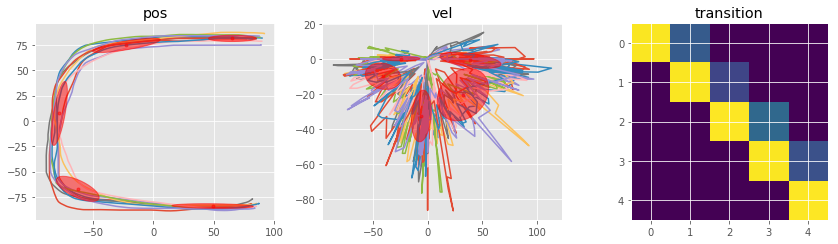

In [17]:
model = pbd.HSMM(nb_states=5, nb_dim=4)

model.init_hmm_kbins(data_xdx) # initializing model

# EM to train model
model.em(data_xdx, reg=1e-2) 


# plotting
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,3.5)

# position plotting
ax[0].set_title('pos')
for p in data_x:
    ax[0].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 

# velocity plotting
ax[1].set_title('vel')
for p in data_dx:
    ax[1].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 


# plotting transition matrix
ax[2].set_title('transition')
ax[2].imshow(np.log(model.Trans+1e-10), interpolation='nearest', vmin=-5, cmap='viridis');
plt.tight_layout()

### Plot duration distribution 

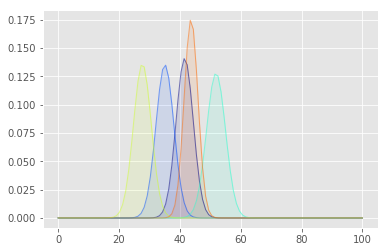

In [18]:
for i in range(model.nb_states):
    pbd.plot_gaussian1d(model.mu_d[i], model.sigma_d[i], [0, 100], color=plt.cm.jet(i * 255/model.nb_states));

# Reproduction (LQR) 
Using Product of Gaussian formulation with augmented transfer matrices see : http://calinon.ch/papers/Calinon-HFR2016.pdf

### Get forward variable 

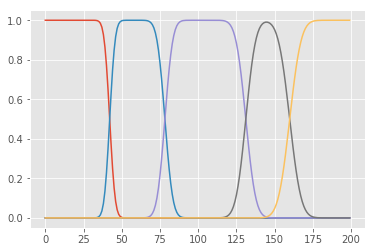

In [19]:
alpha_hsmm, _, _, _, _ = model.compute_messages(marginal=[], sample_size=data_x[0].shape[0])

plt.plot(alpha_hsmm.T);

### Get sequence of states 

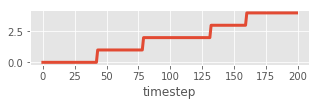

In [20]:
sq = np.argmax(alpha_hsmm, axis=0)

plt.figure(figsize=(5, 1))
# plt.axis('off')
plt.plot(sq, lw=3);
plt.xlabel('timestep');

## Create and solve LQR 

In [21]:
A, b = pbd.utils.get_canonical(2, 2, 0.1)

In [22]:
lqr = pbd.LQR(A, b, horizon=data_xdx[0].shape[0])
lqr.gmm_xi = model, sq
lqr.gmm_u = -4.

In [23]:
lqr.ricatti()

In [24]:
xi, _ = lqr.get_seq(data_xdx[0][0])

## Plotting reproduced trajectory (position and velocity)

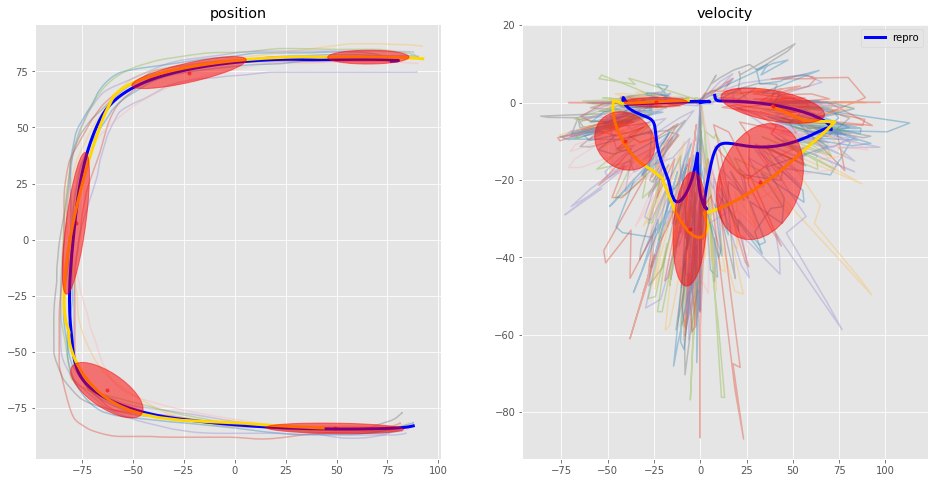

In [25]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16,8)


# position plotting 
ax[0].set_title('position')
for p in data_x:
    ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 
    
ax[0].plot(xi[:, 0], xi[:, 1], 'b', lw=3)
ax[0].plot(lqr.ds[:, 0], lqr.ds[:, 1], 'gold', lw=3)


# velocity plotting
ax[1].set_title('velocity')
for p in data_dx:
    ax[1].plot(p[:, 0], p[:, 1], alpha=0.4)
    
ax[1].plot(xi[:, 2], xi[:, 3], 'b', lw=3, label='repro')
ax[1].plot(lqr.ds[:, 2], lqr.ds[:, 3], 'gold', lw=3)

plt.legend()
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 


## Average Mean Squared Errors

In [26]:
mse = 0
if len(data_xdx) > 1:
    gt = np.array(data_xdx).mean(axis = 0)
else:
    gt = np.array(data_xdx[0])

for i in range(len(xi)):
    mse = mse + pow(xi[i]-gt[i], 2)
mse = mse/len(xi)
mse = np.array([math.sqrt(pow(mse[0], 2) + pow(mse[1], 2)), math.sqrt(pow(mse[2], 2) + pow(mse[3], 2))])

mse

array([ 83.36, 222.67])

In [27]:
def cal_mse(data, xi):
    mse = 0
    if len(data) > 1:
        gt = np.array(data).mean(axis = 0)
    else:
        gt = np.array(data[0])

    for i in range(len(xi)):
        mse = mse + pow(xi[i]-gt[i], 2)
    mse = mse/len(xi)
    mse = np.array([math.sqrt(pow(mse[0], 2) + pow(mse[1], 2)), math.sqrt(pow(mse[2], 2) + pow(mse[3], 2))])
    return mse

In [28]:
mse = cal_mse(data_xdx, xi)
mse

array([ 83.36, 222.67])

In [29]:
alpha_hsmm, _, _, _, _ = model.compute_messages(marginal=[], sample_size=data_x[0].shape[0])
sq = np.argmax(alpha_hsmm, axis=0)
A, b = pbd.utils.get_canonical(2, 2, 0.1)
lqr = pbd.LQR(A, b, horizon=data_xdx[0].shape[0])
lqr.gmm_xi = model, sq
lqr.gmm_u = -4.
lqr.ricatti()

xi, _ = lqr.get_seq(data_xdx_half[0][0])

In [194]:
alpha_hsmm, _, _, _, _ = model.compute_messages(marginal=[], sample_size=data_x[0].shape[0])
sq = np.argmax(alpha_hsmm, axis=0)
A, b = pbd.utils.get_canonical(2, 2, 0.1)
lqr = pbd.LQR(A, b, horizon=data_xdx[0].shape[0])
lqr.gmm_xi = model, sq
lqr.gmm_u = -4.
lqr.ricatti()

xi, _ = lqr.get_seq(data_xdx_half[0][0])

# find the nearest point of xi to mydata_xdx[0][-1]
temp = 99999
for i in range(len(xi)):
    diff = cal_distance(xi[i][0:2], data_xdx_half[0][-1][0:2])
    if diff <= temp:
        point_id = i
        temp = diff

xi = xi[point_id:]
#xi = xi[point_id:].tolist()
#xi = np.array([data_xdx_half[0][-1]] + xi)

In [195]:
point_id

116

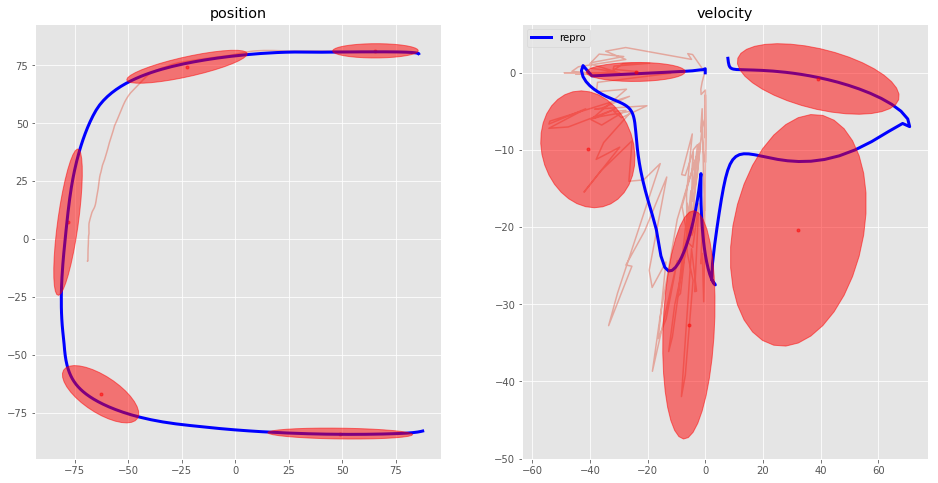

In [30]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16,8)


# position plotting 
ax[0].set_title('position')
for p in data_x_half:
    ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 
    
ax[0].plot(xi[:, 0], xi[:, 1], 'b', lw=3)
#ax[0].plot(lqr.ds[:, 0], lqr.ds[:, 1], 'gold', lw=3)


# velocity plotting
ax[1].set_title('velocity')
for p in data_dx_half:
    ax[1].plot(p[:, 0], p[:, 1], alpha=0.4)
    
ax[1].plot(xi[:, 2], xi[:, 3], 'b', lw=3, label='repro')
#ax[1].plot(lqr.ds[:, 2], lqr.ds[:, 3], 'gold', lw=3)

plt.legend()
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 


In [31]:
repro_x, repro_dx = separate_xdx(xi)
repro_x = np.array(repro_x)

In [32]:
data_x_half = np.array(data_x_half[0])
data_x_half.shape

(169, 2)

In [28]:
np.savetxt('data_half.txt', data_x_half, delimiter=' ')
np.savetxt('repro.txt', repro_x, delimiter=' ')

In [33]:
X = np.loadtxt('./mydataset/data_half.txt')
Y = np.loadtxt('./mydataset/repro_half.txt')

In [34]:
res_B = [[0.91033867, -0.03809387], [0.0569461, 1.11588233]]
res_t = [3.62910512, -6.93882696]
res = np.dot(repro_x, res_B) + np.tile(res_t, (repro_x.shape[0], 1))

In [38]:
point_id = getClosestID(data_x_half[-1][0:2], res)
res = res[point_id:]

In [39]:
point_id = getClosestID(data_x_half[-1][0:2], xi)
repro_x = repro_x[point_id:]

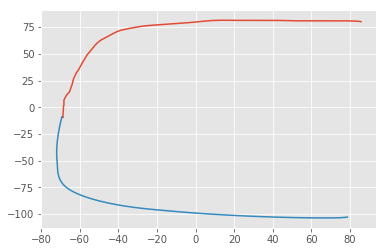

In [40]:
plt.plot(data_x_half[:,0], data_x_half[:,1])
plt.plot(res[:,0], res[:,1])
plt.show()

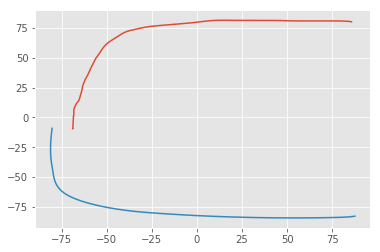

In [41]:
plt.plot(data_x_half[:,0], data_x_half[:,1])
plt.plot(repro_x[:,0], repro_x[:,1])
plt.show()

In [34]:
point_id = getClosestID(data_x_half[-1][0:2], xi)

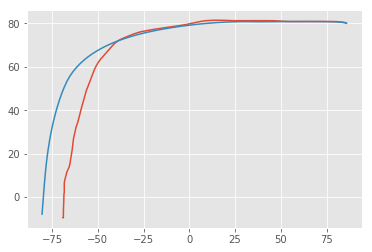

In [35]:
plt.plot(data_x_half[:,0], data_x_half[:,1])
test = repro_x[:point_id]
plt.plot(test[:,0], test[:,1])
plt.show()

In [34]:
np.savetxt('repro_half.txt', test, delimiter=' ')

In [33]:
xi.shape

(199, 4)

In [37]:
# find the nearest point of point(x,y) to all points in dataset
def getClosestID(point, dataset):
    temp = 99999
    for i in range(len(dataset)):
        diff = cal_distance(dataset[i][0:2], point[0:2])
        if diff <= temp:
            point_id = i
            temp = diff
    return point_id

# calculate the distance between point p1 and p2
def cal_distance(p1, p2):
    return math.sqrt(math.pow((p2[0] - p1[0]), 2) + math.pow((p2[1] - p1[1]), 2))

# calculate the arc tangent of y/x in radians:
def cal_theta(p1, p2):
    return math.atan2(p2[1]-p1[1], p2[0]-p1[0])

# calculate the mean distance between two datasets
# dataset1 --> data_x_half
# dataset2 --> xi
def cal_distance_datasets(dataset1, dataset2):
    loss = 0
    for i in range(len(dataset1)):
        point_id = getClosestID(dataset1[i][0:2], dataset2)     
        diff = cal_distance(dataset1[i][0:2], dataset2[point_id][0:2])
        loss = loss + diff
    return loss/len(dataset1)

In [35]:
# data_x_half --> dataset --> target dataset --> A
# xi --> source dataset --> B
def my_icp(xi, dataset):
    
    iteration = 0
    diff_curr = 100
    diff_improved = 100
    diff_before = cal_distance_datasets(dataset, xi)
    
#     while iteration < 500 and diff_improved > 0.001:
    while diff_curr > 10:
        
        x_mean_dataset = np.mean(dataset, axis=0)[0]
        y_mean_dataset = np.mean(dataset, axis=0)[1]
        x_mean_xi = np.mean(xi, axis=0)[0]
        y_mean_xi = np.mean(xi, axis=0)[1]
        
        dataset_ = dataset - np.array([[x_mean_dataset, y_mean_dataset]])
        xi_ = xi - np.array([[x_mean_xi, y_mean_xi]])
        
        w_num = 0
        w_den = 0
        for i in range(len(dataset_)):
            point_id = getClosestID(dataset_[i][0:2], xi_)
            w_num_i = dataset_[i][0]*xi_[point_id][1] - dataset_[i][1]*xi_[point_id][0]
            w_den_i = dataset_[i][0]*xi_[point_id][0] - dataset_[i][1]*xi_[point_id][1]
#             w_num_i = dataset_[i][0]*xi_[i][1] - dataset_[i][1]*xi_[i][0]
#             w_den_i = dataset_[i][0]*dataset_[i][1] + xi_[i][0]*xi_[i][1]
#             w_num_i = dataset_[i][0]*xi_[point_id][1] - dataset_[i][1]*xi_[point_id][0]
#             w_den_i = dataset_[i][0]*dataset_[i][1] + xi_[point_id][0]*xi_[point_id][1]
            w_num = w_num + w_num_i
            w_den = w_den + w_den_i
            
        theta = math.atan2(w_num, w_den)
        offset_x = x_mean_dataset - math.cos(theta)*x_mean_xi - math.sin(theta)*y_mean_xi
        offset_y = y_mean_dataset - math.sin(theta)*x_mean_xi - math.cos(theta)*y_mean_xi
        R = np.array([[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]])
        xi = np.matmul(xi, R) + np.array([[offset_x, offset_y]])
        
        iteration = iteration + 1
        diff_curr = cal_distance_datasets(dataset, xi)
        diff_improved = abs(diff_before - diff_curr)
        print('After ' + str(iteration) + ' iteration(s), the current loss is ' + str(diff_curr) + ', the improved loss is ' + str(diff_improved))
        diff_before = diff_curr
        
    return xi

In [38]:
test.shape

(114, 2)

In [39]:
xi_icp = my_icp(repro_x, data_x_half)

After 1 iteration(s), the current loss is 44.7876293854, the improved loss is 38.5698628131
After 2 iteration(s), the current loss is 35.2482052224, the improved loss is 9.53942416296
After 3 iteration(s), the current loss is 51.2644864831, the improved loss is 16.0162812607
After 4 iteration(s), the current loss is 33.6777979067, the improved loss is 17.5866885764
After 5 iteration(s), the current loss is 30.4340743786, the improved loss is 3.2437235281
After 6 iteration(s), the current loss is 51.7860798286, the improved loss is 21.3520054499
After 7 iteration(s), the current loss is 33.2571827926, the improved loss is 18.528897036
After 8 iteration(s), the current loss is 30.830281497, the improved loss is 2.42690129559
After 9 iteration(s), the current loss is 39.6220691884, the improved loss is 8.79178769136
After 10 iteration(s), the current loss is 31.5771897784, the improved loss is 8.04487941003
After 11 iteration(s), the current loss is 33.0014949608, the improved loss is 1.4

After 94 iteration(s), the current loss is 32.1608591488, the improved loss is 1.77075166624
After 95 iteration(s), the current loss is 39.9772486359, the improved loss is 7.81638948702
After 96 iteration(s), the current loss is 46.3490158538, the improved loss is 6.37176721797
After 97 iteration(s), the current loss is 32.7316615296, the improved loss is 13.6173543243
After 98 iteration(s), the current loss is 51.018443103, the improved loss is 18.2867815734
After 99 iteration(s), the current loss is 33.8251701113, the improved loss is 17.1932729917
After 100 iteration(s), the current loss is 30.9518292041, the improved loss is 2.8733409072
After 101 iteration(s), the current loss is 51.1892182245, the improved loss is 20.2373890203
After 102 iteration(s), the current loss is 31.2742148481, the improved loss is 19.9150033764
After 103 iteration(s), the current loss is 45.9588186551, the improved loss is 14.684603807
After 104 iteration(s), the current loss is 33.3922997967, the improv

After 182 iteration(s), the current loss is 33.6014678747, the improved loss is 12.6891438505
After 183 iteration(s), the current loss is 33.3380368904, the improved loss is 0.263430984324
After 184 iteration(s), the current loss is 30.7680427132, the improved loss is 2.56999417718
After 185 iteration(s), the current loss is 45.9115068295, the improved loss is 15.1434641163
After 186 iteration(s), the current loss is 33.581370211, the improved loss is 12.3301366185
After 187 iteration(s), the current loss is 33.600740826, the improved loss is 0.0193706149946
After 188 iteration(s), the current loss is 30.2164922898, the improved loss is 3.38424853625
After 189 iteration(s), the current loss is 45.9191307623, the improved loss is 15.7026384725
After 190 iteration(s), the current loss is 33.5818512502, the improved loss is 12.3372795121
After 191 iteration(s), the current loss is 33.5947712563, the improved loss is 0.0129200061542
After 192 iteration(s), the current loss is 30.1731083893

After 271 iteration(s), the current loss is 33.2545674997, the improved loss is 0.485875333565
After 272 iteration(s), the current loss is 30.6707276777, the improved loss is 2.58383982196
After 273 iteration(s), the current loss is 40.6249490601, the improved loss is 9.95422138236
After 274 iteration(s), the current loss is 28.7883127312, the improved loss is 11.8366363289
After 275 iteration(s), the current loss is 29.137921068, the improved loss is 0.349608336785
After 276 iteration(s), the current loss is 29.1576911374, the improved loss is 0.0197700694003
After 277 iteration(s), the current loss is 29.5380985943, the improved loss is 0.380407456896
After 278 iteration(s), the current loss is 30.47624751, the improved loss is 0.938148915702
After 279 iteration(s), the current loss is 31.7364396997, the improved loss is 1.26019218969
After 280 iteration(s), the current loss is 33.0190472501, the improved loss is 1.28260755047
After 281 iteration(s), the current loss is 33.9201279376

After 360 iteration(s), the current loss is 40.5971670852, the improved loss is 9.67775485787
After 361 iteration(s), the current loss is 28.499586225, the improved loss is 12.0975808602
After 362 iteration(s), the current loss is 29.1429070006, the improved loss is 0.643320775591
After 363 iteration(s), the current loss is 29.2506668137, the improved loss is 0.107759813051
After 364 iteration(s), the current loss is 30.001105172, the improved loss is 0.750438358336
After 365 iteration(s), the current loss is 31.1305088899, the improved loss is 1.12940371785
After 366 iteration(s), the current loss is 32.5088557108, the improved loss is 1.37834682093
After 367 iteration(s), the current loss is 33.5985162543, the improved loss is 1.08966054348
After 368 iteration(s), the current loss is 33.3678752785, the improved loss is 0.230640975725
After 369 iteration(s), the current loss is 30.9993016595, the improved loss is 2.36857361899
After 370 iteration(s), the current loss is 49.2871171759,

After 449 iteration(s), the current loss is 51.2113633483, the improved loss is 17.8542027897
After 450 iteration(s), the current loss is 33.7241684148, the improved loss is 17.4871949335
After 451 iteration(s), the current loss is 30.8830329035, the improved loss is 2.84113551123
After 452 iteration(s), the current loss is 51.6393954856, the improved loss is 20.7563625821
After 453 iteration(s), the current loss is 32.9824515019, the improved loss is 18.6569439837
After 454 iteration(s), the current loss is 33.4690940017, the improved loss is 0.486642499737
After 455 iteration(s), the current loss is 51.0438116097, the improved loss is 17.574717608
After 456 iteration(s), the current loss is 33.7983030313, the improved loss is 17.2455085784
After 457 iteration(s), the current loss is 30.7141792595, the improved loss is 3.0841237718
After 458 iteration(s), the current loss is 51.216207886, the improved loss is 20.5020286266
After 459 iteration(s), the current loss is 30.5741166713, the

After 537 iteration(s), the current loss is 30.0314839786, the improved loss is 3.31686003337
After 538 iteration(s), the current loss is 40.5315728176, the improved loss is 10.500088839
After 539 iteration(s), the current loss is 28.4759457184, the improved loss is 12.0556270992
After 540 iteration(s), the current loss is 28.9965206014, the improved loss is 0.520574883014
After 541 iteration(s), the current loss is 29.3584001931, the improved loss is 0.361879591706
After 542 iteration(s), the current loss is 30.3547024946, the improved loss is 0.996302301512
After 543 iteration(s), the current loss is 31.4947522063, the improved loss is 1.14004971175
After 544 iteration(s), the current loss is 32.8425200183, the improved loss is 1.34776781191
After 545 iteration(s), the current loss is 33.890463457, the improved loss is 1.04794343874
After 546 iteration(s), the current loss is 32.8858052257, the improved loss is 1.00465823134
After 547 iteration(s), the current loss is 31.3397383025, 

After 628 iteration(s), the current loss is 30.7938190347, the improved loss is 2.89088812587
After 629 iteration(s), the current loss is 51.9270476655, the improved loss is 21.1332286308
After 630 iteration(s), the current loss is 33.4416488552, the improved loss is 18.4853988103
After 631 iteration(s), the current loss is 31.2105801149, the improved loss is 2.23106874033
After 632 iteration(s), the current loss is 49.8790422387, the improved loss is 18.6684621238
After 633 iteration(s), the current loss is 33.8825083795, the improved loss is 15.9965338593
After 634 iteration(s), the current loss is 32.5414207659, the improved loss is 1.34108761355
After 635 iteration(s), the current loss is 35.7202320073, the improved loss is 3.17881124139
After 636 iteration(s), the current loss is 51.887064695, the improved loss is 16.1668326877
After 637 iteration(s), the current loss is 33.4990023565, the improved loss is 18.3880623385
After 638 iteration(s), the current loss is 30.0732734113, th

After 716 iteration(s), the current loss is 30.3719998038, the improved loss is 2.82543693985
After 717 iteration(s), the current loss is 40.5199577694, the improved loss is 10.1479579656
After 718 iteration(s), the current loss is 28.5758926105, the improved loss is 11.9440651589
After 719 iteration(s), the current loss is 28.9820811284, the improved loss is 0.406188517902
After 720 iteration(s), the current loss is 29.3268698333, the improved loss is 0.34478870491
After 721 iteration(s), the current loss is 30.3579724556, the improved loss is 1.03110262228
After 722 iteration(s), the current loss is 31.4952265452, the improved loss is 1.13725408959
After 723 iteration(s), the current loss is 32.8448709371, the improved loss is 1.34964439194
After 724 iteration(s), the current loss is 33.8917450739, the improved loss is 1.04687413675
After 725 iteration(s), the current loss is 32.9001163357, the improved loss is 0.991628738141
After 726 iteration(s), the current loss is 31.4702104439,

After 805 iteration(s), the current loss is 33.4734183884, the improved loss is 1.06309884696
After 806 iteration(s), the current loss is 33.7377224653, the improved loss is 0.264304076866
After 807 iteration(s), the current loss is 30.1148294225, the improved loss is 3.62289304281
After 808 iteration(s), the current loss is 49.6224553813, the improved loss is 19.5076259587
After 809 iteration(s), the current loss is 33.9232513045, the improved loss is 15.6992040767
After 810 iteration(s), the current loss is 32.5712014836, the improved loss is 1.35204982095
After 811 iteration(s), the current loss is 36.5136326873, the improved loss is 3.94243120376
After 812 iteration(s), the current loss is 51.2099526038, the improved loss is 14.6963199165
After 813 iteration(s), the current loss is 31.0969267941, the improved loss is 20.1130258097
After 814 iteration(s), the current loss is 47.8308510191, the improved loss is 16.733924225
After 815 iteration(s), the current loss is 30.6078917619, t

After 895 iteration(s), the current loss is 40.5410807954, the improved loss is 9.73874797852
After 896 iteration(s), the current loss is 28.2771405982, the improved loss is 12.2639401972
After 897 iteration(s), the current loss is 28.9991752471, the improved loss is 0.722034648834
After 898 iteration(s), the current loss is 29.4893351927, the improved loss is 0.490159945598
After 899 iteration(s), the current loss is 30.3911910866, the improved loss is 0.901855893915
After 900 iteration(s), the current loss is 31.5648258321, the improved loss is 1.1736347455
After 901 iteration(s), the current loss is 32.9783696629, the improved loss is 1.41354383085
After 902 iteration(s), the current loss is 33.8287673683, the improved loss is 0.850397705348
After 903 iteration(s), the current loss is 32.6040050555, the improved loss is 1.22476231277
After 904 iteration(s), the current loss is 33.5536003535, the improved loss is 0.949595298039
After 905 iteration(s), the current loss is 42.821998984

After 985 iteration(s), the current loss is 33.5080716342, the improved loss is 18.3758248719
After 986 iteration(s), the current loss is 30.1400337889, the improved loss is 3.36803784527
After 987 iteration(s), the current loss is 40.5822527186, the improved loss is 10.4422189297
After 988 iteration(s), the current loss is 28.4772096501, the improved loss is 12.1050430685
After 989 iteration(s), the current loss is 29.1098808397, the improved loss is 0.632671189597
After 990 iteration(s), the current loss is 29.2119208191, the improved loss is 0.102039979484
After 991 iteration(s), the current loss is 30.1150131551, the improved loss is 0.90309233599
After 992 iteration(s), the current loss is 31.3446211752, the improved loss is 1.22960802005
After 993 iteration(s), the current loss is 32.6935344536, the improved loss is 1.34891327844
After 994 iteration(s), the current loss is 33.7248182728, the improved loss is 1.03128381922
After 995 iteration(s), the current loss is 33.4176876524,

After 1073 iteration(s), the current loss is 28.6242053036, the improved loss is 11.9899872666
After 1074 iteration(s), the current loss is 28.7733857486, the improved loss is 0.149180444936
After 1075 iteration(s), the current loss is 29.2343112501, the improved loss is 0.460925501566
After 1076 iteration(s), the current loss is 29.9671875338, the improved loss is 0.732876283637
After 1077 iteration(s), the current loss is 30.9989774085, the improved loss is 1.03178987478
After 1078 iteration(s), the current loss is 32.3708705727, the improved loss is 1.37189316414
After 1079 iteration(s), the current loss is 33.4717418457, the improved loss is 1.10087127299
After 1080 iteration(s), the current loss is 33.5517472846, the improved loss is 0.0800054388768
After 1081 iteration(s), the current loss is 30.5580308497, the improved loss is 2.99371643487
After 1082 iteration(s), the current loss is 51.1596994571, the improved loss is 20.6016686074
After 1083 iteration(s), the current loss is 

After 1161 iteration(s), the current loss is 43.4750835088, the improved loss is 11.7838536941
After 1162 iteration(s), the current loss is 37.3575659303, the improved loss is 6.11751757859
After 1163 iteration(s), the current loss is 51.8460289702, the improved loss is 14.4884630399
After 1164 iteration(s), the current loss is 32.313493803, the improved loss is 19.5325351671
After 1165 iteration(s), the current loss is 38.4016872335, the improved loss is 6.08819343047
After 1166 iteration(s), the current loss is 48.0420299856, the improved loss is 9.6403427521
After 1167 iteration(s), the current loss is 30.0700353929, the improved loss is 17.9719945927
After 1168 iteration(s), the current loss is 40.537450811, the improved loss is 10.4674154181
After 1169 iteration(s), the current loss is 28.3613862426, the improved loss is 12.1760645684
After 1170 iteration(s), the current loss is 29.0052703518, the improved loss is 0.643884109256
After 1171 iteration(s), the current loss is 29.4448

After 1251 iteration(s), the current loss is 29.2295488599, the improved loss is 0.173895843688
After 1252 iteration(s), the current loss is 29.9617577734, the improved loss is 0.732208913568
After 1253 iteration(s), the current loss is 30.9349266236, the improved loss is 0.973168850229
After 1254 iteration(s), the current loss is 32.3629172909, the improved loss is 1.4279906673
After 1255 iteration(s), the current loss is 33.4617145725, the improved loss is 1.09879728152
After 1256 iteration(s), the current loss is 33.605134259, the improved loss is 0.143419686563
After 1257 iteration(s), the current loss is 29.9750434156, the improved loss is 3.63009084341
After 1258 iteration(s), the current loss is 45.9587391263, the improved loss is 15.9836957107
After 1259 iteration(s), the current loss is 33.5923267966, the improved loss is 12.3664123297
After 1260 iteration(s), the current loss is 33.5877045573, the improved loss is 0.00462223922356
After 1261 iteration(s), the current loss is 

After 1339 iteration(s), the current loss is 51.2037143247, the improved loss is 14.6645912474
After 1340 iteration(s), the current loss is 31.1842435021, the improved loss is 20.0194708227
After 1341 iteration(s), the current loss is 48.0455688286, the improved loss is 16.8613253266
After 1342 iteration(s), the current loss is 30.0817058394, the improved loss is 17.9638629892
After 1343 iteration(s), the current loss is 40.546082839, the improved loss is 10.4643769996
After 1344 iteration(s), the current loss is 28.3109573509, the improved loss is 12.235125488
After 1345 iteration(s), the current loss is 28.995920202, the improved loss is 0.684962851047
After 1346 iteration(s), the current loss is 29.4645044837, the improved loss is 0.468584281744
After 1347 iteration(s), the current loss is 30.3526700404, the improved loss is 0.888165556648
After 1348 iteration(s), the current loss is 31.4570509776, the improved loss is 1.10438093721
After 1349 iteration(s), the current loss is 32.80

After 1427 iteration(s), the current loss is 33.6927695895, the improved loss is 17.1714441918
After 1428 iteration(s), the current loss is 30.5883722264, the improved loss is 3.10439736311
After 1429 iteration(s), the current loss is 51.7691230316, the improved loss is 21.1807508052
After 1430 iteration(s), the current loss is 32.581259561, the improved loss is 19.1878634706
After 1431 iteration(s), the current loss is 36.580303051, the improved loss is 3.99904348999
After 1432 iteration(s), the current loss is 51.1928270129, the improved loss is 14.6125239619
After 1433 iteration(s), the current loss is 31.3817405573, the improved loss is 19.8110864556
After 1434 iteration(s), the current loss is 48.3480474918, the improved loss is 16.9663069345
After 1435 iteration(s), the current loss is 30.3172417547, the improved loss is 18.0308057371
After 1436 iteration(s), the current loss is 42.9345183649, the improved loss is 12.6172766102
After 1437 iteration(s), the current loss is 33.0820

After 1514 iteration(s), the current loss is 40.6173697312, the improved loss is 10.0267502824
After 1515 iteration(s), the current loss is 28.6701549318, the improved loss is 11.9472147994
After 1516 iteration(s), the current loss is 28.8881827485, the improved loss is 0.218027816723
After 1517 iteration(s), the current loss is 29.2402054417, the improved loss is 0.352022693178
After 1518 iteration(s), the current loss is 29.7996960911, the improved loss is 0.559490649426
After 1519 iteration(s), the current loss is 30.8149199457, the improved loss is 1.01522385458
After 1520 iteration(s), the current loss is 32.1082219065, the improved loss is 1.29330196077
After 1521 iteration(s), the current loss is 33.3037201359, the improved loss is 1.19549822948
After 1522 iteration(s), the current loss is 33.6946217444, the improved loss is 0.390901608496
After 1523 iteration(s), the current loss is 30.5889389278, the improved loss is 3.10568281664
After 1524 iteration(s), the current loss is 5

After 1602 iteration(s), the current loss is 28.5546662854, the improved loss is 12.0509638804
After 1603 iteration(s), the current loss is 29.0511207797, the improved loss is 0.496454494391
After 1604 iteration(s), the current loss is 29.2283519876, the improved loss is 0.177231207849
After 1605 iteration(s), the current loss is 29.9694353235, the improved loss is 0.741083335921
After 1606 iteration(s), the current loss is 30.9834481945, the improved loss is 1.01401287099
After 1607 iteration(s), the current loss is 32.3412407804, the improved loss is 1.35779258589
After 1608 iteration(s), the current loss is 33.4575630922, the improved loss is 1.1163223118
After 1609 iteration(s), the current loss is 33.6630279029, the improved loss is 0.205464810724
After 1610 iteration(s), the current loss is 30.4583377168, the improved loss is 3.20469018615
After 1611 iteration(s), the current loss is 50.8596181212, the improved loss is 20.4012804044
After 1612 iteration(s), the current loss is 33

After 1692 iteration(s), the current loss is 29.0364072496, the improved loss is 0.290502504075
After 1693 iteration(s), the current loss is 28.9985832844, the improved loss is 0.0378239651189
After 1694 iteration(s), the current loss is 29.7432859162, the improved loss is 0.744702631772
After 1695 iteration(s), the current loss is 30.5524257298, the improved loss is 0.809139813535
After 1696 iteration(s), the current loss is 31.9584111125, the improved loss is 1.40598538277
After 1697 iteration(s), the current loss is 33.2446276618, the improved loss is 1.28621654924
After 1698 iteration(s), the current loss is 33.8938175844, the improved loss is 0.649189922615
After 1699 iteration(s), the current loss is 30.9624391474, the improved loss is 2.93137843699
After 1700 iteration(s), the current loss is 47.9217927047, the improved loss is 16.9593535573
After 1701 iteration(s), the current loss is 31.0493522577, the improved loss is 16.872440447
After 1702 iteration(s), the current loss is 

After 1782 iteration(s), the current loss is 32.9252614379, the improved loss is 12.9566063688
After 1783 iteration(s), the current loss is 45.7597762504, the improved loss is 12.8345148124
After 1784 iteration(s), the current loss is 33.5759636386, the improved loss is 12.1838126117
After 1785 iteration(s), the current loss is 33.7119593086, the improved loss is 0.135995669998
After 1786 iteration(s), the current loss is 29.9347111696, the improved loss is 3.77724813902
After 1787 iteration(s), the current loss is 46.1224849956, the improved loss is 16.187773826
After 1788 iteration(s), the current loss is 33.6020137019, the improved loss is 12.5204712937
After 1789 iteration(s), the current loss is 33.5021768178, the improved loss is 0.0998368840686
After 1790 iteration(s), the current loss is 30.6606817088, the improved loss is 2.84149510896
After 1791 iteration(s), the current loss is 49.4420684587, the improved loss is 18.7813867499
After 1792 iteration(s), the current loss is 33.

After 1870 iteration(s), the current loss is 46.1275636408, the improved loss is 16.1936263833
After 1871 iteration(s), the current loss is 33.601604851, the improved loss is 12.5259587898
After 1872 iteration(s), the current loss is 33.4983860968, the improved loss is 0.10321875426
After 1873 iteration(s), the current loss is 30.6595674295, the improved loss is 2.83881866731
After 1874 iteration(s), the current loss is 49.4825792788, the improved loss is 18.8230118494
After 1875 iteration(s), the current loss is 33.8028260074, the improved loss is 15.6797532714
After 1876 iteration(s), the current loss is 32.2466867718, the improved loss is 1.55613923563
After 1877 iteration(s), the current loss is 38.0928880459, the improved loss is 5.84620127411
After 1878 iteration(s), the current loss is 49.9077649634, the improved loss is 11.8148769175
After 1879 iteration(s), the current loss is 30.3932008264, the improved loss is 19.514564137
After 1880 iteration(s), the current loss is 51.0279

After 1957 iteration(s), the current loss is 29.0530816058, the improved loss is 11.5843309952
After 1958 iteration(s), the current loss is 29.4817991468, the improved loss is 0.42871754101
After 1959 iteration(s), the current loss is 29.0564187606, the improved loss is 0.425380386191
After 1960 iteration(s), the current loss is 29.229389831, the improved loss is 0.17297107039
After 1961 iteration(s), the current loss is 29.9694485971, the improved loss is 0.740058766147
After 1962 iteration(s), the current loss is 30.9495460502, the improved loss is 0.980097453097
After 1963 iteration(s), the current loss is 32.366780012, the improved loss is 1.41723396178
After 1964 iteration(s), the current loss is 33.462413925, the improved loss is 1.09563391305
After 1965 iteration(s), the current loss is 33.5859031808, the improved loss is 0.123489255803
After 1966 iteration(s), the current loss is 29.8266647408, the improved loss is 3.75923843999
After 1967 iteration(s), the current loss is 40.7

After 2045 iteration(s), the current loss is 32.1725005303, the improved loss is 14.0542359602
After 2046 iteration(s), the current loss is 45.9170204937, the improved loss is 13.7445199635
After 2047 iteration(s), the current loss is 33.5805629194, the improved loss is 12.3364575744
After 2048 iteration(s), the current loss is 33.5895888401, the improved loss is 0.00902592073833
After 2049 iteration(s), the current loss is 30.1343069744, the improved loss is 3.45528186576
After 2050 iteration(s), the current loss is 46.2671221621, the improved loss is 16.1328151878
After 2051 iteration(s), the current loss is 33.5966119567, the improved loss is 12.6705102054
After 2052 iteration(s), the current loss is 33.3317944476, the improved loss is 0.264817509098
After 2053 iteration(s), the current loss is 30.7404575068, the improved loss is 2.59133694087
After 2054 iteration(s), the current loss is 46.0006080589, the improved loss is 15.2601505521
After 2055 iteration(s), the current loss is 3

After 2135 iteration(s), the current loss is 29.5380829359, the improved loss is 0.369301810805
After 2136 iteration(s), the current loss is 30.4761737205, the improved loss is 0.938090784671
After 2137 iteration(s), the current loss is 31.7349149028, the improved loss is 1.25874118224
After 2138 iteration(s), the current loss is 33.0190464536, the improved loss is 1.28413155079
After 2139 iteration(s), the current loss is 33.9201390732, the improved loss is 0.901092619663
After 2140 iteration(s), the current loss is 32.5432226278, the improved loss is 1.37691644541
After 2141 iteration(s), the current loss is 36.3152714624, the improved loss is 3.77204883456
After 2142 iteration(s), the current loss is 51.6825267363, the improved loss is 15.3672552739
After 2143 iteration(s), the current loss is 32.8582436228, the improved loss is 18.8242831135
After 2144 iteration(s), the current loss is 32.6745571991, the improved loss is 0.183686423687
After 2145 iteration(s), the current loss is 4

After 2223 iteration(s), the current loss is 31.5752369756, the improved loss is 14.5163896888
After 2224 iteration(s), the current loss is 40.6190313781, the improved loss is 9.04379440255
After 2225 iteration(s), the current loss is 28.6840628255, the improved loss is 11.9349685527
After 2226 iteration(s), the current loss is 28.93693834, the improved loss is 0.252875514507
After 2227 iteration(s), the current loss is 29.2919309991, the improved loss is 0.354992659147
After 2228 iteration(s), the current loss is 29.7569196956, the improved loss is 0.464988696506
After 2229 iteration(s), the current loss is 30.6486527529, the improved loss is 0.891733057239
After 2230 iteration(s), the current loss is 31.9949413973, the improved loss is 1.34628864449
After 2231 iteration(s), the current loss is 33.2113589259, the improved loss is 1.21641752854
After 2232 iteration(s), the current loss is 33.88941486, the improved loss is 0.678055934121
After 2233 iteration(s), the current loss is 32.0

After 2311 iteration(s), the current loss is 33.5978351354, the improved loss is 1.05518813556
After 2312 iteration(s), the current loss is 33.4037875606, the improved loss is 0.194047574847
After 2313 iteration(s), the current loss is 30.2995718874, the improved loss is 3.10421567315
After 2314 iteration(s), the current loss is 40.6208534977, the improved loss is 10.3212816103
After 2315 iteration(s), the current loss is 28.7381535316, the improved loss is 11.8826999662
After 2316 iteration(s), the current loss is 28.9984124474, the improved loss is 0.260258915852
After 2317 iteration(s), the current loss is 29.0397095791, the improved loss is 0.0412971317266
After 2318 iteration(s), the current loss is 29.756741196, the improved loss is 0.717031616887
After 2319 iteration(s), the current loss is 30.6624903061, the improved loss is 0.905749110027
After 2320 iteration(s), the current loss is 32.0109488793, the improved loss is 1.34845857321
After 2321 iteration(s), the current loss is 

After 2398 iteration(s), the current loss is 32.4467111551, the improved loss is 8.38372714762
After 2399 iteration(s), the current loss is 33.5609704399, the improved loss is 1.11425928474
After 2400 iteration(s), the current loss is 33.579541979, the improved loss is 0.0185715391656
After 2401 iteration(s), the current loss is 30.8010950944, the improved loss is 2.77844688464
After 2402 iteration(s), the current loss is 51.9142527916, the improved loss is 21.1131576972
After 2403 iteration(s), the current loss is 33.4619634474, the improved loss is 18.4522893442
After 2404 iteration(s), the current loss is 31.3374055453, the improved loss is 2.12455790206
After 2405 iteration(s), the current loss is 49.3644124854, the improved loss is 18.02700694
After 2406 iteration(s), the current loss is 33.8222037429, the improved loss is 15.5422087425
After 2407 iteration(s), the current loss is 32.4515639546, the improved loss is 1.37063978831
After 2408 iteration(s), the current loss is 35.969

After 2488 iteration(s), the current loss is 39.6318554915, the improved loss is 7.39732458085
After 2489 iteration(s), the current loss is 48.2303884222, the improved loss is 8.59853293067
After 2490 iteration(s), the current loss is 30.9939378054, the improved loss is 17.2364506168
After 2491 iteration(s), the current loss is 49.3116000613, the improved loss is 18.3176622559
After 2492 iteration(s), the current loss is 33.824228569, the improved loss is 15.4873714923
After 2493 iteration(s), the current loss is 32.5335968356, the improved loss is 1.29063173344
After 2494 iteration(s), the current loss is 36.2939995015, the improved loss is 3.76040266588
After 2495 iteration(s), the current loss is 51.714740907, the improved loss is 15.4207414055
After 2496 iteration(s), the current loss is 32.7452414874, the improved loss is 18.9694994195
After 2497 iteration(s), the current loss is 34.8243592421, the improved loss is 2.07911775472
After 2498 iteration(s), the current loss is 51.7026

After 2575 iteration(s), the current loss is 30.3119013143, the improved loss is 17.7814500352
After 2576 iteration(s), the current loss is 40.622788437, the improved loss is 10.3108871227
After 2577 iteration(s), the current loss is 28.7470249809, the improved loss is 11.8757634561
After 2578 iteration(s), the current loss is 29.0277814645, the improved loss is 0.280756483602
After 2579 iteration(s), the current loss is 28.9722067846, the improved loss is 0.0555746799106
After 2580 iteration(s), the current loss is 29.7488733237, the improved loss is 0.776666539142
After 2581 iteration(s), the current loss is 30.6243024051, the improved loss is 0.875429081329
After 2582 iteration(s), the current loss is 31.9502867331, the improved loss is 1.32598432807
After 2583 iteration(s), the current loss is 33.240053947, the improved loss is 1.28976721384
After 2584 iteration(s), the current loss is 33.9154399639, the improved loss is 0.675386016916
After 2585 iteration(s), the current loss is 3

KeyboardInterrupt: 

NameError: name 'xi_icp' is not defined

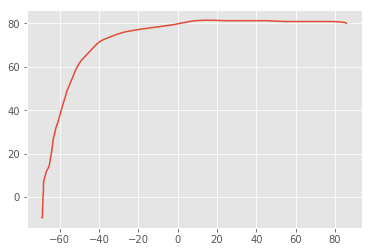

In [40]:
plt.plot(data_x_half[:,0], data_x_half[:,1])
# plt.plot(xi[:,0], xi[:,1])
plt.plot(xi_icp[:,0], xi_icp[:,1])
plt.show()